In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd



# Define the CNN architecture
class LoRaCNN(nn.Module):
    def __init__(self, M):
        super(LoRaCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=M//4, kernel_size=4, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=M//4, out_channels=M//2, kernel_size=4, stride=1, padding=2)
        
        # Pooling layer
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(M//2 * (M//4) * (M//4), 4 * M)  
        self.fc2 = nn.Linear(4 * M, 2 * M)
        self.fc3 = nn.Linear(2 * M, M)
        
    def forward(self, x):
        # Input shape is (batch_size, 1, M, M)
        
        # Convolutional layers
        x = F.relu(self.conv1(x))  # Apply ReLU to conv1
        x = self.pool(x)           # Apply average pooling
        x = F.relu(self.conv2(x))  # Apply ReLU to conv2
        x = self.pool(x)           # Apply average pooling
        
        # Flatten the output from conv layers
        x = x.view(-1, self.num_flat_features(x))
        
        # Fully connected layers
        x = F.relu(self.fc1(x))    # First fully connected layer
        x = F.relu(self.fc2(x))    # Second fully connected layer
        x = self.fc3(x)            # Output layer with no activation (softmax in loss)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # All dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Example parameters
M = 128  # Number of possible values per symbol (2^SF for SF=7)

# Create the CNN model
model = LoRaCNN(M)

# Example loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Example training loop
def train(model, train_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Print statistics
            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f'Epoch [{epoch+1}], Step [{i+1}], Loss: {running_loss / 100:.4f}')
                running_loss = 0.0

# Example input size and dummy data for testing the model
# Assuming inputs are MxM matrix and labels are the symbol class (0 to M-1)
#batch_size = 32
#inputs = torch.randn(batch_size, 1, M, M)  # Random inputs, batch_size x 1 x M x M
#labels = torch.randint(0, M, (batch_size,))  # Random labels in range [0, M)

# Convert inputs into a DataLoader for batch processing (dummy example)
#from torch.utils.data import DataLoader, TensorDataset
#train_data = TensorDataset(inputs, labels)
#train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Train the model (for demonstration purposes, only 2 epochs)
#train(model, train_loader, num_epochs=2)

# Save the trained model
#torch.save(model.state_dict(), 'lora_cnn_model.pth')


In [64]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch

# Define a custom dataset
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, specific_label=None, transform=None):
        self.img_dir = img_dir
        self.img_list = os.listdir(img_dir)
        self.transform = transform
        self.specific_label = specific_label 

        if specific_label is not None:
            self.img_list = [img for img in self.img_list if float(img.split('_')[1]) == specific_label]


    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        # Get the image filename
        img_name = self.img_list[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Extract the label from the filename (assuming filenames are like 'class_0_image1.png')
        # Adjust this line if your filename format is different
        label = int(img_name.split('_')[3])  # Extract label assuming the label is after 'class_'

        # Load the image
        image = Image.open(img_path).convert("L")  # Convert to grayscale if necessary

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Convert the label to a tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize with mean and std
])

# Set path to the folder containing the images
img_dir = "./first_data_set/plots/"  # Update this path accordingly

# Create the dataset and DataLoader
dataset = CustomImageDataset(img_dir=img_dir, specific_label=-4.0, transform=transform)


# Assuming dataset is your complete dataset
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
test_size = dataset_size - train_size  # 20% for testing

# Split the dataset into training and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check dataset and DataLoader
print(f"Number of images in dataset: {len(dataset)}")
image, label = dataset[0]
print(f"Example image shape: {image.shape}, Label: {label}")



Number of images in dataset: 6993
Example image shape: torch.Size([1, 128, 128]), Label: 47


In [65]:
M = 128  # Define the value according to your model requirements
model = LoRaCNN(M)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model using the train function defined previously
train(model, train_loader, 2)

Epoch [1], Step [100], Loss: 0.2657
Epoch [2], Step [100], Loss: 0.0000


In [66]:
def evaluate_and_calculate_ser(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    correct_predictions = 0
    total_predictions = 0
    total_loss = 0.0
    incorrect_predictions = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)
            
            # Calculate number of correct and incorrect predictions
            correct_predictions += (predicted == labels).sum().item()
            incorrect_predictions += (predicted != labels).sum().item()
            total_predictions += labels.size(0)

    # Calculate accuracy
    accuracy = 100 * correct_predictions / total_predictions
    
    # Calculate Symbol Error Rate (SER)
    ser = incorrect_predictions / total_predictions

    # Calculate average loss
    average_loss = total_loss / len(test_loader)

    print(f'Validation/Test Loss: {average_loss:.4f}')
    print(f'Validation/Test Accuracy: {accuracy:.2f}%')
    print(f'Symbol Error Rate (SER): {ser:.6f}')
    return ser

# Evaluate the model and calculate SER on the test set
evaluate_and_calculate_ser(model, test_loader, criterion)


Validation/Test Loss: 0.0000
Validation/Test Accuracy: 100.00%
Symbol Error Rate (SER): 0.000000


0.0

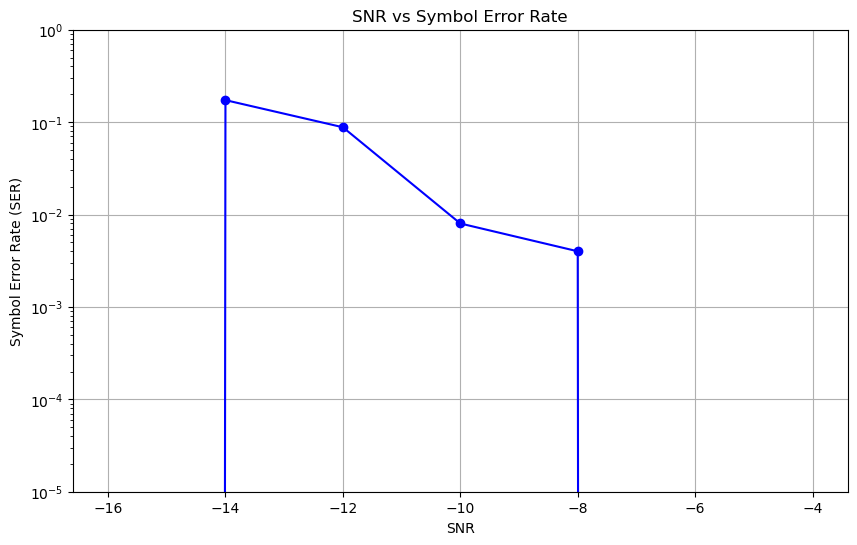

In [76]:
import matplotlib.pyplot as plt

specific_values = [i for i in range(-16, -2, 2)]
symbol_error_rates = [0, 0.173, 0.088, 0.008, 0.004, 0, 0]



plt.figure(figsize=(10, 6))
plt.plot(specific_values, symbol_error_rates, marker='o', linestyle='-', color='b')
plt.xlabel('SNR')
plt.ylabel('Symbol Error Rate (SER)')
plt.yscale('log')
plt.ylim(1e-5, 1e0)
plt.title('SNR vs Symbol Error Rate')
plt.grid(True)
plt.show()
    



In [42]:
float(1)

1.0

In [68]:
specific_values = [i for i in range(-16, -4, 2)]

In [69]:
specific_values

[-16, -14, -12, -10, -8, -6]